In [1]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *
from model import *
from trainer import *

from tqdm.notebook import tqdm
from torch.optim.adam import Adam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = 'Data/Variants/SIR/omicron/*.csv'
dic_files = Load_files.load_files(path, -14, -12)
data = dic_files['대구']
data

,stdDay,Susceptible,22D_Infected,22D_Recovered,22D_Dead,22D_alpha,22D_beta,22D_gamma,23A_Infected,23A_Recovered,23A_Dead,23A_alpha,23A_beta,23A_gamma
0,2022-12-19,1154500,7646.89,28392.09,32.73,0.470884,0.191027,0.000145,9.73,0.00,0.00,7.709827,0.000000,0.000000
1,2022-12-20,1150875,7925.02,29852.85,33.84,0.454658,0.172557,0.000233,45.98,0.00,0.00,1.632581,0.000000,0.000000
2,2022-12-21,1147259,8291.33,31220.37,35.69,0.385427,0.137623,0.000134,82.14,0.00,0.00,0.810531,0.000000,0.000000
3,2022-12-22,1144062,8683.70,32361.45,36.80,0.306706,0.122074,0.000170,114.11,0.00,0.00,0.486252,0.000000,0.000000
4,2022-12-23,1141405,8897.53,33421.50,38.28,0.319341,0.127748,0.000125,140.68,0.00,0.00,0.420776,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,2023-04-30,1031603,503.31,104434.19,135.79,0.106662,0.063420,0.000000,1695.36,9178.20,10.14,0.106662,0.063420,0.000000
133,2023-05-01,1031481,494.57,104466.11,135.79,0.427119,0.164426,0.000384,1665.92,9285.72,10.14,0.427119,0.164426,0.000384
134,2023-05-02,1031001,504.26,104547.43,135.98,0.405137,0.161266,0.000377,1698.56,9559.64,10.78,0.405137,0.161266,0.000377
135,2023-05-03,1030537,510.91,104628.75,136.17,0.505227,0.147267,0.000000,1720.96,9833.56,11.42,0.505227,0.147267,0.000000


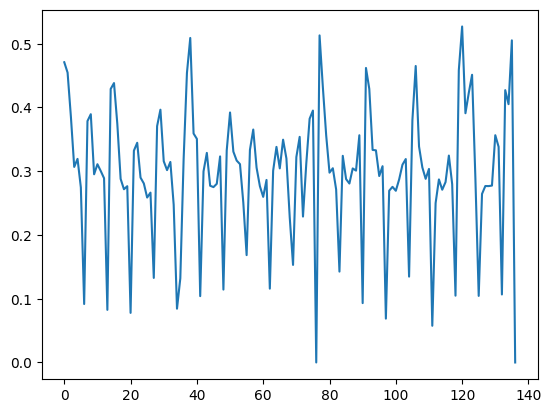

In [3]:
plt.plot(data['22D_alpha'])

In [14]:
path = 'hyperparameter/SIR/22D/*.pkl'
files = glob.glob(path)
dic_hyperparameter = {}
for file in files:
    dic_hyperparameter[file[23:-4]] = load_hyperparameter(file)
    
dic_hyperparameter

{'BiGRU': [1002, 0.0001, 50, 4, 64, 32, 0.25],
 'BiLSTM': [220, 0.001, 20, 2, 32, 16, 0.25],
 'BiRNN': [287, 0.001, 20, 8, 64, 8, 0.25],
 'GRU': [260, 0.001, 20, 1, 32, 8, 0.25],
 'LSTM': [483, 0.001, 50, 2, 64, 32, 0.25],
 'RNN': [217, 0.0001, 20, 4, 32, 8, 0.25],
 'seq2seq_BiGRU': [1043, 0.001, 50, 1, 64, 32, 0.25, MSELoss()],
 'seq2seq_BiLSTM': [1056,
  0.001,
  50,
  4,
  32,
  32,
  0.25,
  <function utils.criterion3(actual, predict)>],
 'seq2seq_BiRNN': [929,
  0.001,
  50,
  1,
  64,
  8,
  0.25,
  <function utils.criterion2(actual, predict)>],
 'seq2seq_GRU': [1237, 0.001, 50, 2, 32, 16, 0.25, MSELoss()],
 'seq2seq_LSTM': [500,
  0.001,
  20,
  1,
  64,
  32,
  0.25,
  <function utils.criterion3(actual, predict)>],
 'seq2seq_RNN': [439,
  0.001,
  20,
  2,
  64,
  16,
  0.25,
  <function utils.criterion3(actual, predict)>]}

In [16]:
dic_model = load_model_multiple(dic_hyperparameter, 'SIR', '22D')

In [17]:
df = Prepare_df.processing(data, 'stdDay', '22D_alpha')

predicted_values = {}
num_model = 0
for name, state in dic_model.items():
    batch_size = dic_hyperparameter[name][4]
    if num_model < 6:
        x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 68, 60, 1, batch_size, 'mto')
        label_y, predicted = predict_mto(state, df, x_ss, y_ms)
        predicted_values[name] = [label_y, predicted]
    else:
        x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 62, 60, 7, batch_size, 'mtm')
        label_y, predicted, first_label_y, first_predicted, all_predicted = predict_mtm(state, df, x_ss, y_ms, 7, 0.5, device)
        predicted_values[name] = [label_y, predicted, first_label_y, first_predicted, all_predicted]

    num_model += 1

In [18]:
actual_data = predicted_values['RNN'][0]

0.14282243516700005


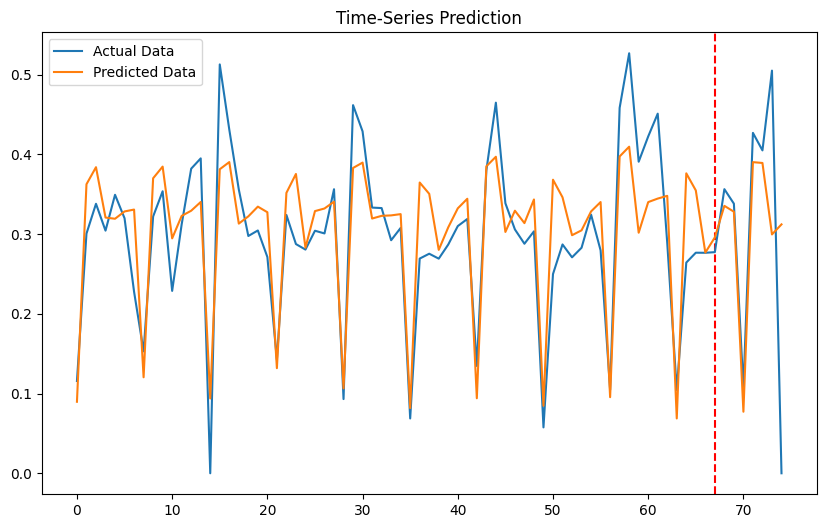

In [19]:
print(rmse(actual_data[-7:], predicted_values['RNN'][1][-7:]))
plotting(actual_data, predicted_values['RNN'][1], 67)

0.15002833113744088


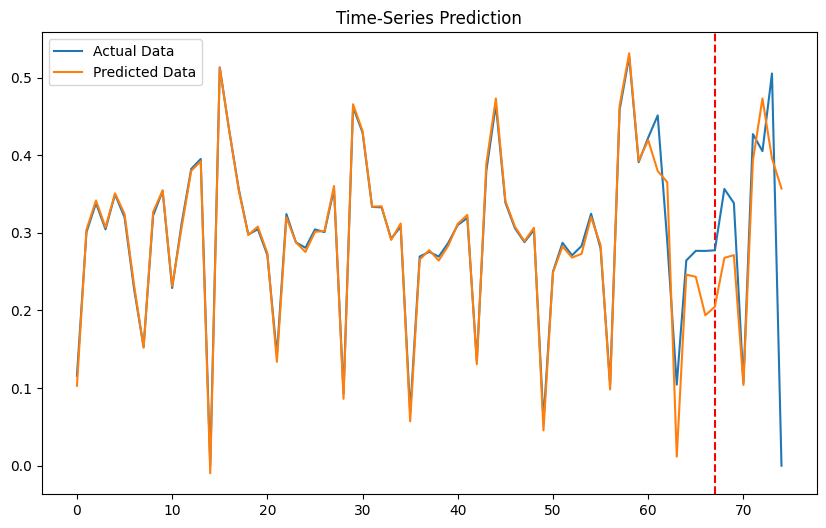

In [20]:
print(rmse(actual_data[-7:], predicted_values['LSTM'][1][-7:]))
plotting(actual_data, predicted_values['LSTM'][1], 67)

0.1355839843411497


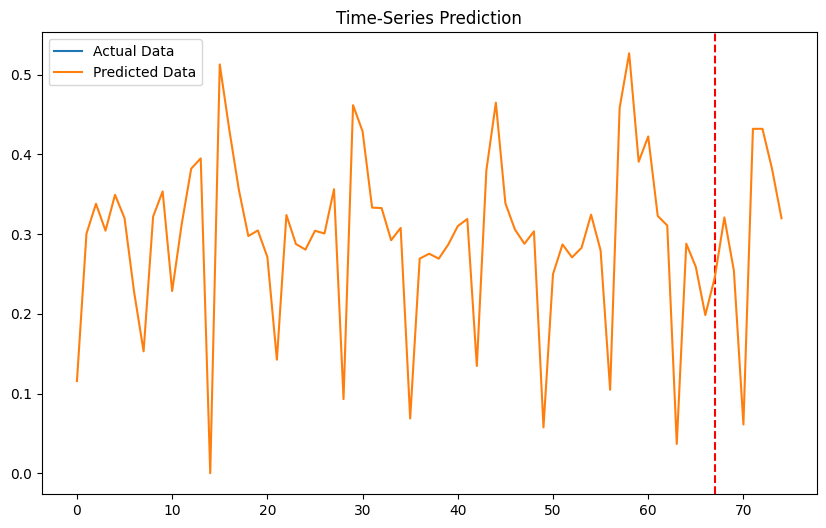

In [21]:
print(rmse(actual_data[-7:], predicted_values['GRU'][1][-7:]))
plotting(actual_data[0], predicted_values['GRU'][1], 67)

0.2583975655677253


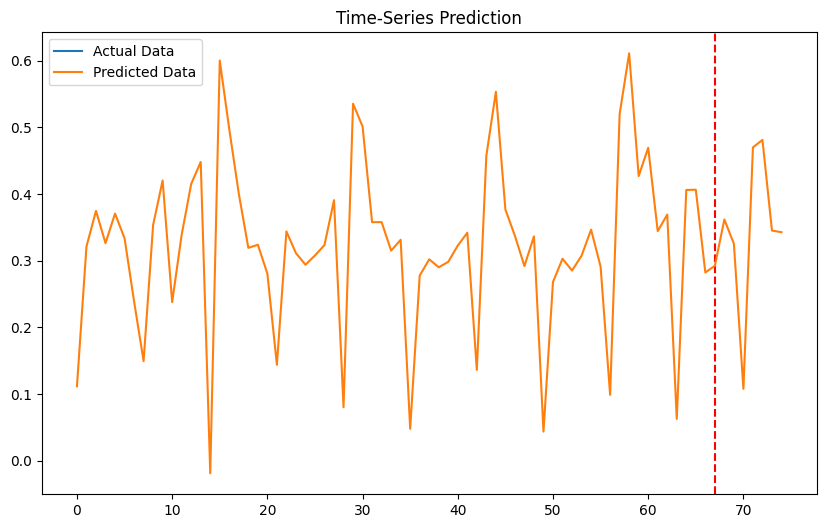

In [22]:
print(rmse(actual_data[0][-7:], predicted_values['BiRNN'][1][-7:]))
plotting(actual_data[0], predicted_values['BiRNN'][1], 67)

0.14657746853674822


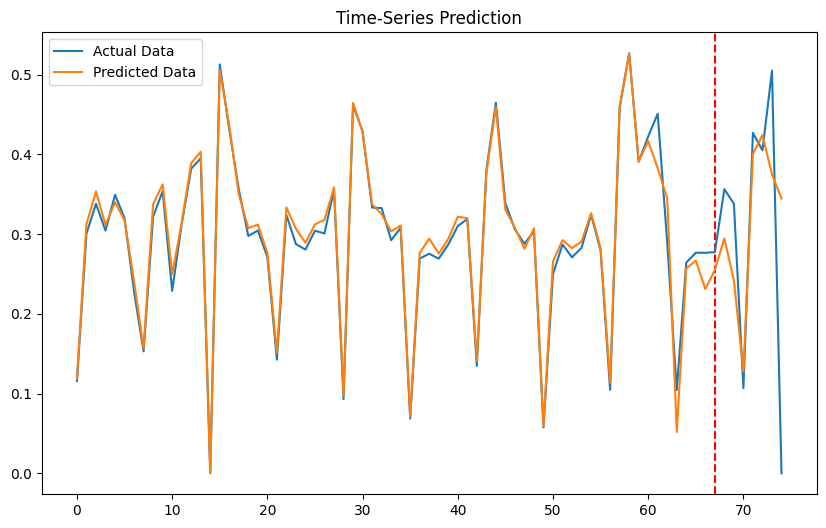

In [23]:
print(rmse(actual_data[-7:], predicted_values['BiLSTM'][1][-7:]))
plotting(actual_data, predicted_values['BiLSTM'][1], 67)

0.1506112758925332


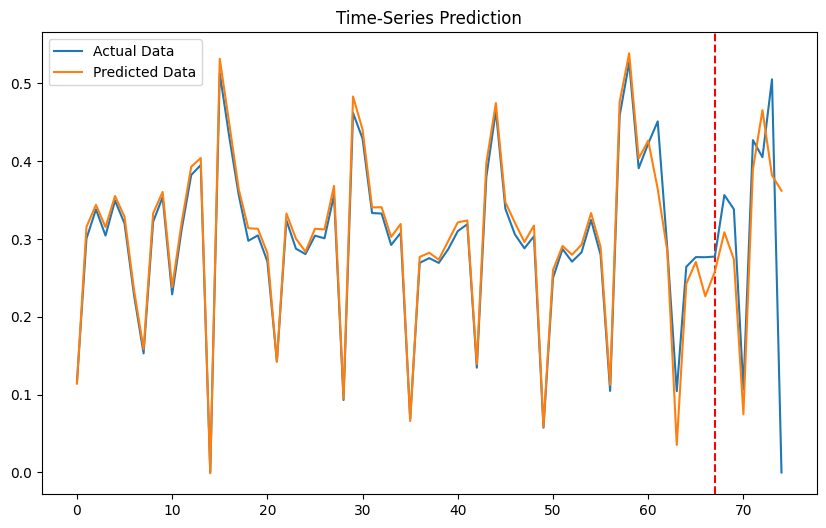

In [24]:
print(rmse(actual_data[-7:], predicted_values['BiGRU'][1][-7:]))
plotting(actual_data, predicted_values['BiGRU'][1], 67)

0.1314629399806864


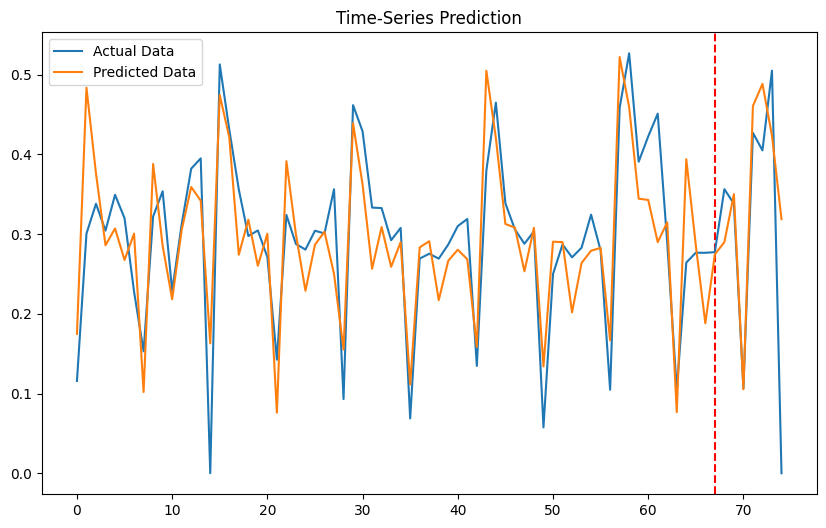

In [25]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_RNN'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_RNN'][4], 67)

0.12581491819399065


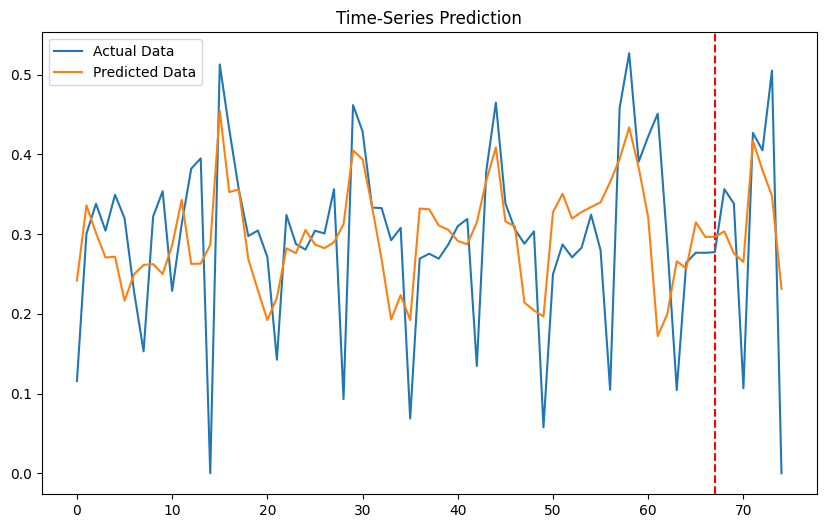

In [26]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_LSTM'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_LSTM'][4], 67)

0.13054865628710283


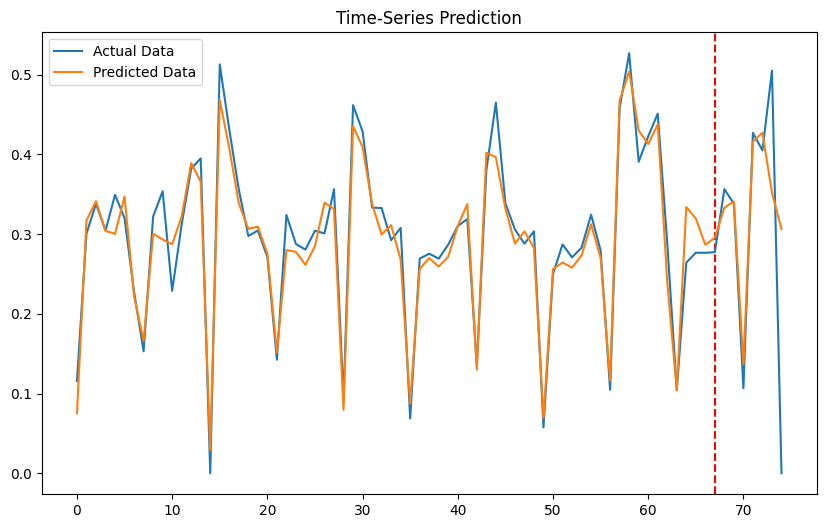

In [27]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_GRU'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_GRU'][4], 67)

0.13921333100147182


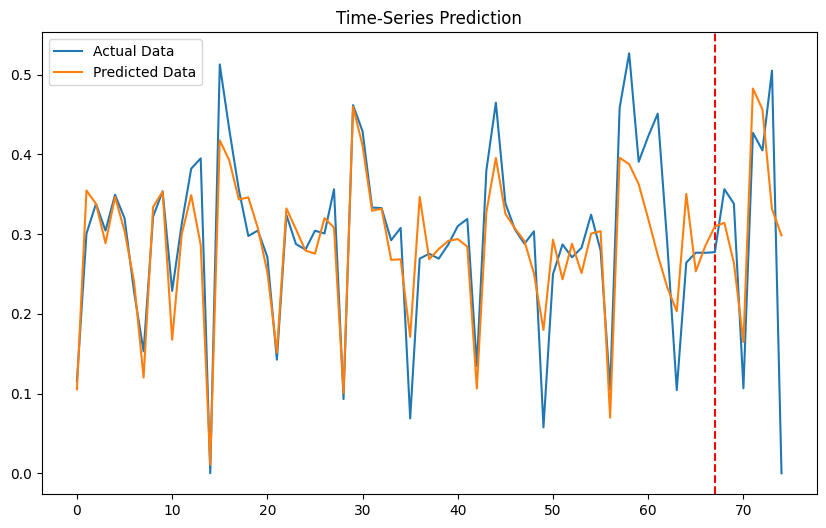

In [28]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_BiRNN'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_BiRNN'][4], 67)

0.13243706315073403


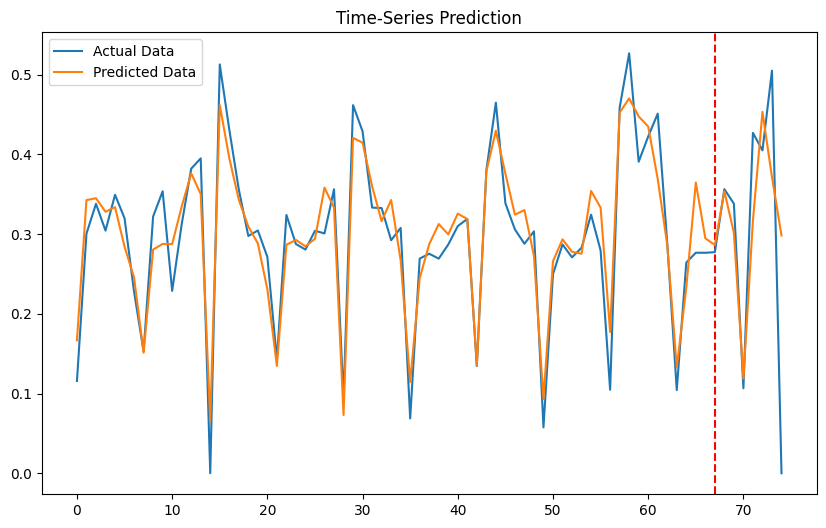

In [29]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_BiLSTM'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_BiLSTM'][4], 67)

0.15129265950105764


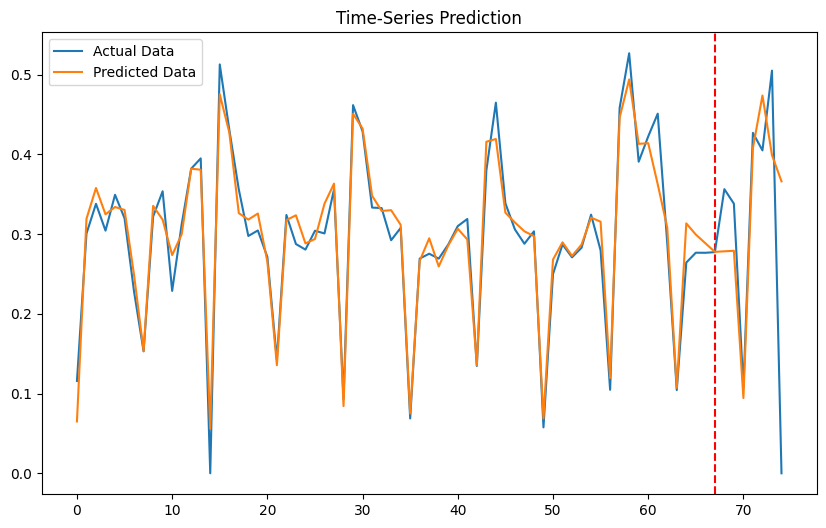

In [30]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_BiGRU'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_BiGRU'][4], 67)

In [108]:
best_model = 'RNN'
datetime_index = data['stdDay'][-1*len(actual_data):]
df_predicted = pd.DataFrame()
df_predicted = pd.DataFrame(np.concatenate([actual_data, predicted_values[best_model][1]], axis = 1), index = datetime_index, columns = ['22D_origin', '22D_Predicted'])
df_predicted.to_csv(f'Data/Predicted/Variants/Infected/22D_{best_model}.csv')

In [109]:
df_predicted

,22D_origin,22D_Predicted
stdDay,,
2023-02-19,406.800018,408.157684
2023-02-20,162.720001,163.359482
2023-02-21,406.800018,407.955811
2023-02-22,433.440002,434.280945
2023-02-23,366.480011,367.396088
...,...,...
2023-04-30,75.239998,73.961258
2023-05-01,23.180000,26.184658
2023-05-02,91.200005,91.019356
